# FINAL PROJECT

This final project is an analysis of the network of spotify music artists. In particular, the artists are the nodes, and the edges are the featuring between them.
The chosen dataset can be found at:
https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?select=nodes.csv

In [3]:
# basic imports
import numpy as np
from numpy import linalg as LA
import pandas as pd # useful dataframe support
import scipy as sp
from matplotlib import pyplot as plt # plot operations
import networkx as nx # useful for network operations
import nltk # useful for sentence parsing
import re # regular expressions for text parsing and finding proper names
import networkx.algorithms.community as nx_comm
import sklearn
from sklearn.cluster import SpectralClustering
!pip install communities
import communities.algorithms as comm
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for communities: filename=communities-3.0.0-py3-none-any.whl size=18297 sha256=79f6216ccf961136b591907327d0d089ea3d8e25164820315e902d0fc361f7a8
  Stored in directory: /root/.cache/pip/wheels/31/bd/0d/ee858a987d6c59be4a442939cd6612b086c32f59c1203bd8ee
Successfully built communities


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## PART 1: Data preprocessing

In this first part, data is stored in the structures used for the whole project and modified if needed.

In [12]:
# Mount my google drive and make it acessible as if it were a local
# file system
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
f="/content/drive/MyDrive/LINMA2472/edges.csv" 
feats = pd.read_csv(f)



In [15]:
a="/content/drive/MyDrive/LINMA2472/nodes.csv" 
artists = pd.read_csv(a)

print(feats.head())
print(artists.head())

                     id_0                    id_1
0  76M2Ekj8bG8W7X2nbx2CpF  7sfl4Xt5KmfyDs2T3SVSMK
1  0hk4xVujcyOr6USD95wcWb  7Do8se3ZoaVqUt3woqqSrD
2  38jpuy3yt3QIxQ8Fn1HTeJ  4csQIMQm6vI2A2SCVDuM2z
3  6PvcxssrQ0QaJVaBWHD07l  6UCQYrcJ6wab6gnQ89OJFh
4  2R1QrQqWuw3IjoP5dXRFjt  4mk1ScvOUkuQzzCZpT6bc0
               spotify_id                name  followers  popularity  \
0  48WvrUGoijadXXCsGocwM4           Byklubben     1738.0          24   
1  4lDiJcOJ2GLCK6p9q5BgfK            Kontra K  1999676.0          72   
2  652XIvIBNGg3C0KIGEJWit               Maxim    34596.0          36   
3  3dXC1YPbnQPsfHPVkm1ipj  Christopher Martin   249233.0          52   
4  74terC9ol9zMo8rfzhSOiG       Jakob Hellman    21193.0          39   

                                              genres  \
0                     ['nordic house', 'russelater']   
1             ['christlicher rap', 'german hip hop']   
2                                                 []   
3  ['dancehall', 'lovers rock', 'modern reg

In [17]:
artists

spotify_id                name  followers  popularity  \
0       48WvrUGoijadXXCsGocwM4           Byklubben     1738.0          24   
1       4lDiJcOJ2GLCK6p9q5BgfK            Kontra K  1999676.0          72   
2       652XIvIBNGg3C0KIGEJWit               Maxim    34596.0          36   
3       3dXC1YPbnQPsfHPVkm1ipj  Christopher Martin   249233.0          52   
4       74terC9ol9zMo8rfzhSOiG       Jakob Hellman    21193.0          39   
...                        ...                 ...        ...         ...   
156417  2ces6d2YsQP1RpGMYpdFy8        David Urwitz     5470.0          29   
156418  6AeznZajNbXUulT7W4tK5l             Darmiko     2022.0          23   
156419  3GEijIjrgb4lPe9WtURBzz            Katriell      268.0           0   
156420  0ldQL0icSoMz9OOZcWG8Zt          Yung Fresh      181.0          19   
156421  1QZqarAGs0Lxx495oNcBnZ       Rakshitha Rao       23.0          24   

                                                   genres  \
0                          ['nordic house', 'russelater']   
1                  ['christlicher rap', 'german hip hop']   
2                                                      []   
3       ['dancehall', 'lovers rock', 'modern reggae', ...   
4       ['classic swedish pop', 'norrbotten indie', 's...   
...                                                   ...   
156417                            ['classic swedish pop']   
156418                                                 []   
156419                                                 []   
156420                                                 []   
156421                                                 []   

                                               chart_hits  
0                                              ['no (3)']  
1       ['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...  
2                                              ['de (1)']  
3                                    ['at (1)', 'de (1)']  
4                                              ['se (6)']  
...                                                   ...  
156417                                                NaN  
156418                                                NaN  
156419                                                NaN  
156420                                                NaN  
156421                                                NaN  

[156422 rows x 6 columns]

In [18]:
#cast all names to string(there are floats) 

for j in range(artists.shape[0]):
    artists.loc[artists.index[j] , 'name'] = str(artists.loc[artists.index[j] , 'name'])


In [19]:
G = nx.Graph()

artists_attr = []
attributes = list(artists.columns.values)
print(attributes)
attributes.remove('spotify_id')

for i in range(len(attributes)):
    artists_attr.append(dict())
    
# add one node per artist
for i in range(len(artists)):
    #add id as node
    current_id = artists.loc[artists.index[i] , 'spotify_id']
    G.add_node(current_id, size = 1)
    
    #create id-attributes dictionary
    for j in range(len(attributes)):
        dict_entry = artists.iloc[i, j+1]
        artists_attr[j][current_id] = dict_entry
    
# add node labels
for i in range(len(attributes)):
    nx.set_node_attributes(G, artists_attr[i], name = attributes[i])

['spotify_id', 'name', 'followers', 'popularity', 'genres', 'chart_hits']


In [20]:
# add the edges
for i in range(len(feats)):
    current_edge = list(feats.iloc[i])
    G.add_edge(current_edge[0], current_edge[1])
    
    
print(nx.info(G))


#print(G.nodes[0][""])

Graph with 156326 nodes and 300386 edges


<ipython-input-20-9a9ff3e180ea>:7: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [21]:
print(G.degree['4mk1ScvOUkuQzzCZpT6bc0'])
names = nx.get_node_attributes(G, "name")

print(list(artists.iloc[100, 1:]))

print('\N{CJK UNIFIED IDEOGRAPH-591C}')

for j in range(artists.shape[0]):
    cur_name = artists.loc[artists.index[j] , 'name']


10
['Mokke', 4495.0, 42, "['swedish drill', 'swedish hip hop', 'swedish trap pop']", "['se (2)']"]
夜


In [ ]:
import matplotlib.font_manager as fm
fprop = fm.FontProperties(fname='./Fonts/NotoSansJP-Black.otf')
fprop = fm.FontProperties(fname='./Fonts/NotoSansThai-Black.ttf')
fprop = fm.FontProperties(fname='./Fonts/NotoSansKR-Black.otf')
fprop = fm.FontProperties(fname='./Fonts/NotoSansTC-Black.ttf')

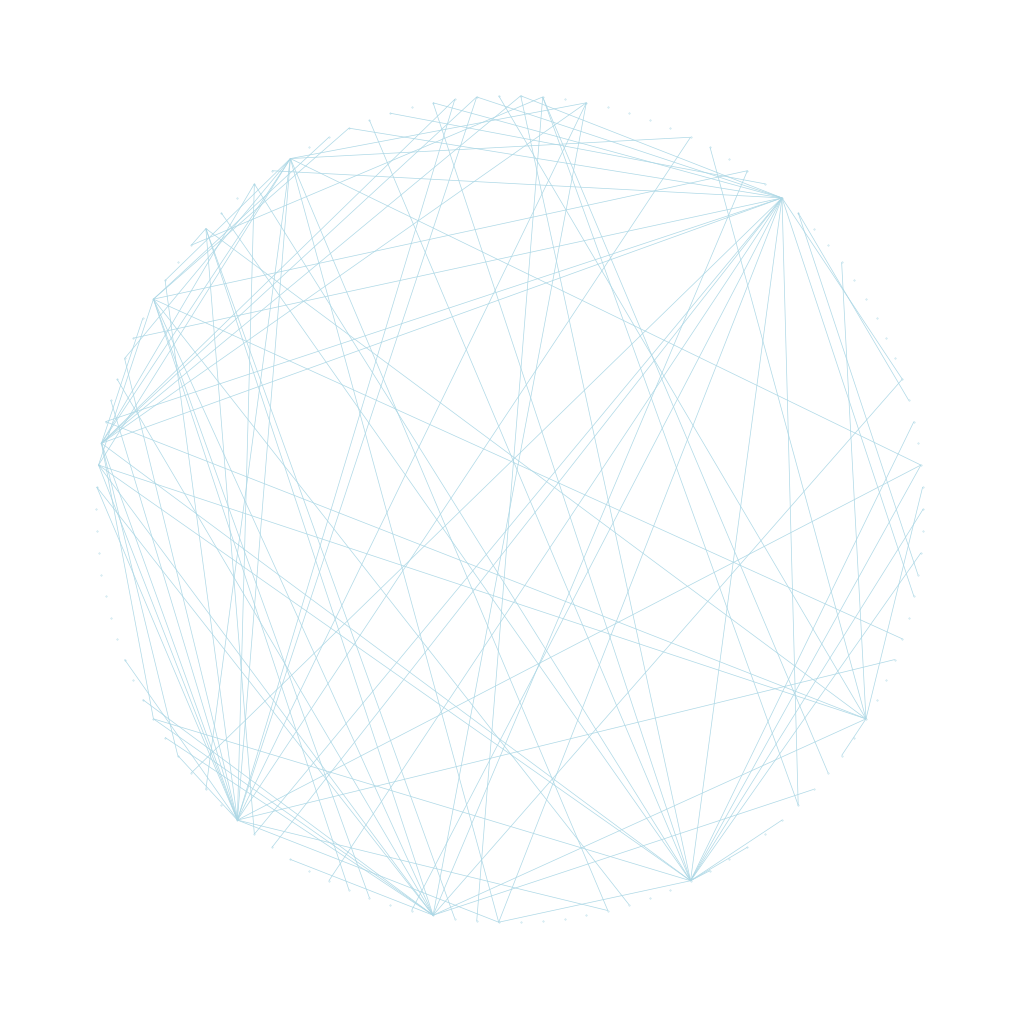

In [ ]:
from matplotlib import pylab
#https://stackoverflow.com/questions/17381006/large-graph-visualization-with-python-and-networkx

def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    #nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

def genre_graph(graph, genre):
    H = nx.Graph()
    genreList = nx.get_node_attributes(graph, "genres")
    ids = list(genreList.keys())
    #print(ids[0])
    #print(genreList[ids[0]])
    
    subgraphNodes = []
    for i in range(len(ids)):
        if genre in genreList[ids[i]]:
            subgraphNodes.append(ids[i])
            
    H = graph.subgraph(subgraphNodes)
    return H

# https://networkx.org/documentation/stable/reference/classes/graph.html
def print_genre(graph, genre):
    H = nx.Graph()
    genreList = nx.get_node_attributes(graph, "genres")
    ids = list(genreList.keys())
    #print(ids[0])
    #print(genreList[ids[0]])
    
    subgraphNodes = []
    for i in range(len(ids)):
        if genre in genreList[ids[i]]:
            subgraphNodes.append(ids[i])
            
    H = graph.subgraph(subgraphNodes)
        
    g_draw = H

    fig = plt.figure(figsize=(10,10))
    pos = nx.circular_layout(g_draw)
    nx.draw(g_draw, pos, node_color='lightblue', edge_color='lightblue', node_size=0.1, with_labels = False, width=0.5)
    
#Assuming that the graph g has nodes and edges entered
#save_graph(G,"my_graph.pdf")
print_genre(G, "modern reggae")
plt.savefig('./Figures/subgraph.png',dpi=300)
plt.show()

How many musical genres are we dealing with here? <br/>
Let's find out!

In [22]:
# Counting the distinct number of genres
genreList = nx.get_node_attributes(G, "genres")
ids_index = list(genreList.keys())
print(len(genreList))
flatList = np.ravel(list(genreList.values()))
genres = set(flatList)
print(len(genres))

156320
19071


That's still a lot of genres! <br/>
Problem: artists usually produce music in more than one genre, very descriptive labels make it hard to group them together. <br/>
Let's try to reduce the number of genres via some text processing so we can have a smaller number of communities.

In [173]:
macroGenres = ['other','pop', 'hip-hop', 'reggae', 'folk', 'electro', 'orchestra', 'rap', 'rock', 'disco', 'house', 'trap', 'funk', 'dance', 'soul', 'synth', 'jazz', 'swing',
              'country', 'blues', 'emo', 'edm', 'metal']

genres = []

#convert list of chars into string
for k in range(len(genreList)):
    words = str(genreList[ids_index[k]])
    words = words.strip("[]")
    words = words.strip(',')
    words = words.split("\'")
    words = [words[i] for i in range(len(words)) if i % 2 == 1]
    genreList[ids_index[k]] = words
            
print(genreList[ids_index[0]][0])

for k in range(len(genreList)):
    counts = np.zeros(len(macroGenres))
    for i in range(len(genreList[ids_index[k]])): #pick the most prevalent macrogenre
        for j in range(1,len(macroGenres)):
            if re.search(macroGenres[j], genreList[ids_index[k]][i]):
                counts[j] += 1
                
    index = np.argmax(counts)
    macroGenre = macroGenres[index]
    genres.append(macroGenre)
    
id_genre = dict()
for i in range(len(genres)):
    id_genre.update({ids_index[i]:genres[i]})
    
# This makes it so a genre like:

nordic house


In [175]:
genreList.values()

dict_values([['nordic house', 'russelater'], ['christlicher rap', 'german hip hop'], [], ['dancehall', 'lovers rock', 'modern reggae', 'reggae fusion'], ['classic swedish pop', 'norrbotten indie', 'swedish pop'], [], ['swedish drill', 'swedish hip hop', 'swedish trap', 'swedish trap pop'], ['francoton'], ['ukrainian hip hop', 'ukrainian pop', 'ukrainian rock'], [], ['norwegian pop rap'], ['suomi rock'], ['orchestral soundtrack', 'soundtrack'], ['japanese dance pop'], [], [], [], ['classic icelandic pop', 'icelandic pop', 'icelandic rock'], [], ['estonian hip hop', 'estonian pop'], ['dancehall', 'jamaican dancehall', 'reggae fusion'], [], ['alternative metal', 'bow pop', 'cello', 'finnish metal', 'nu metal'], ['dance pop', 'pop', 'uk pop'], [], ['c-pop', 'mandopop', 'singaporean mandopop', 'singaporean pop', 'singaporean singer-songwriter'], ['c-pop', 'cantopop'], ['turkish hip hop', 'turkish trap pop'], ['dutch house'], ['pinoy singer-songwriter'], ['thai folk rock', 'thai rock'], ['ar

In [24]:
G2 = G.copy()
nx.set_node_attributes(G2, id_genre, name='genres')

print(nx.get_node_attributes(G2, 'genres')[ids_index[0]])

# gets turned into a genre like:

house


In [25]:
import pickle
  
# Open a file and use dump()
with open('G2.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(G2, file)

In [26]:
# Graph sampling for reducing the dataset to workable size, we will test 3 methods:

'''
Sample a graph to reduce it to only nodes above a certain degree threshold
'''
def sample_graph(graph, thresh=3):
    H = nx.Graph()
    ids = list(graph.nodes)
    subgraphNodes = []
    for i in range(len(ids)):
        if graph.degree[ids[i]] > thresh:
            subgraphNodes.append(ids[i])
            
    H = graph.subgraph(subgraphNodes)
    return H

'''
Sample a graph to reduce it to a random fraction of nodes, this method leaves out A LOT of edges
'''
def sample_graph_random(graph, prob=0.1):
    H = nx.Graph()
    ids = list(graph.nodes)
    subgraphNodes = []
    for i in range(len(ids)):
        if np.random.uniform() < prob:
            subgraphNodes.append(ids[i])
            
    H = graph.subgraph(subgraphNodes)
    return H

'''
Sample a graph by picking nodes with a probability proportional to their degree
'''
def sample_graph_weighted_random(graph):
    H = nx.Graph()
    ids = list(graph.nodes)
    subgraphNodes = []
    H = sample_graph(graph, thresh = 50)
    MaxDeg = 0
    idsH = list(H.nodes)
    for i in range(len(H.nodes)):
        if H.degree[idsH[i]] > MaxDeg:
            MaxDeg = H.degree[idsH[i]]

    for i in range(len(ids)):
        if np.random.uniform() < graph.degree[ids[i]]/MaxDeg:
            subgraphNodes.append(ids[i])
            
    H = graph.subgraph(subgraphNodes)
    return H

# try to find a suitable threshold
H = sample_graph(G2, thresh=15)
R = sample_graph_random(G2, prob=0.05)
W = sample_graph_weighted_random(G2)
print(nx.info(H))
print(nx.info(R))
print(nx.info(W)) # this seems the most well-balanced

<ipython-input-26-9f53eb47e9e0>:56: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(H))


Graph with 7117 nodes and 64211 edges
Graph with 7695 nodes and 816 edges
Graph with 3894 nodes and 16924 edges


<ipython-input-26-9f53eb47e9e0>:57: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(R))
<ipython-input-26-9f53eb47e9e0>:58: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(W)) # this seems the most well-balanced


## Degrees of separation

## With subnetworks

In [ ]:


print(len(list(nx.connected_components(G2))))

G3 = G2.copy()

for component in list(nx.connected_components(G3)):
    if len(component) < 50:
        for node in component:
            G3.remove_node(node)
            

4338


In [ ]:
from networkx.algorithms.distance_measures import center
import heapq
from operator import itemgetter


S = [G3.subgraph(c).copy() for c in nx.connected_components(G3)]



for Gi in S:
    GiNodes = len(Gi.nodes())
    print("Size: ", GiNodes)
    
    GiDiameter = nx.approximation.diameter(Gi)
    print("Diameter: ", GiDiameter)
  
    
    deg_centrality = nx.degree_centrality(Gi)
    print("Centrality len: ", len(deg_centrality))
    
    max_centrality_index = max(deg_centrality, key=deg_centrality.get)
    print(deg_centrality[max_centrality_index])
    
    topitems = heapq.nlargest(10, deg_centrality.items(), key=itemgetter(1))  # Use .iteritems() on Py2
    topitemsasdict = dict(topitems)
    print(topitemsasdict)

Size:  148386
Diameter:  24
Centrality len:  148386
0.012002560905751929
{'5aIqB5nVVvmFsvSdExz408': 0.012002560905751929, '1U5zgr455OGyIkLNXvDdrf': 0.009239478383933686, '0f1IECbrVV952unZkzrsg2': 0.005782255618829397, '4hV3aU0WKvFaiX5ugXP5hp': 0.004259190618997878, '7jzR5qj8vFnSu5JHaXgFEr': 0.0039087508845233685, '0SfsnGyD8FpIN4U4WCkBZ5': 0.0034572227651042896, '13y7CgLHjMVRMDqxdx0Xdo': 0.0034302658624524042, '77AiFEVeAVj2ORpC85QVJs': 0.00335613438015972, '7hJcb9fa4alzcOq3EaNPoG': 0.003335916703170806, '5fMUXHkw8R8eOP2RNVYEZX': 0.0033291774775078345}
Size:  66
Diameter:  4
Centrality len:  66
0.6615384615384616
{'6JZIgN9gEgNSS8lY5pmwbx': 0.6615384615384616, '5PNcqs6EtD6gSXgUiiJIUU': 0.3384615384615385, '4P2x3pFDSDXPLOKWSqUire': 0.03076923076923077, '7ke7u1ie7CdOSUfJCDiaqq': 0.015384615384615385, '2R5y6puYk9qNe1HQ33xgBa': 0.015384615384615385, '0d6XulVq9ygaJm0skxB1sm': 0.015384615384615385, '2yPOJsIUECatn9Etn92Vu4': 0.015384615384615385, '0vDyfou6OAZ1xdG0PUtSyd': 0.015384615384615385, '

In [ ]:
SmallG = S[1]

deg_centrality = nx.betweenness_centrality(SmallG)
print("Centrality len: ", len(deg_centrality))

topitems = heapq.nlargest(2, deg_centrality.items(), key=itemgetter(1))  # Use .iteritems() on Py2
topitemsasdict = dict(topitems)
print(topitemsasdict)

KeyList = list(topitemsasdict.keys())
print(KeyList)

Centrality len:  66
{'6JZIgN9gEgNSS8lY5pmwbx': 0.8783653846153847, '5PNcqs6EtD6gSXgUiiJIUU': 0.5451923076923078}
['6JZIgN9gEgNSS8lY5pmwbx', '5PNcqs6EtD6gSXgUiiJIUU']


In [ ]:
TopArtists = artists[artists['spotify_id'].isin(KeyList)]
print(TopArtists)

                   spotify_id  name  followers  popularity  \
8780   5PNcqs6EtD6gSXgUiiJIUU   颜人中    76407.0          53   
16196  6JZIgN9gEgNSS8lY5pmwbx  音阙诗听    73093.0          48   

                                                  genres  \
8780   ['chinese viral pop', 'taiwan singer-songwriter']   
16196  ['chinese viral pop', 'mainland chinese pop', ...   

                           chart_hits  
8780            ['sg (1)', 'tw (10)']  
16196  ['my (1)', 'sg (1)', 'tw (1)']  


In [ ]:
BigG = S[0]

deg_centrality = nx.degree_centrality(BigG)
print("Centrality len: ", len(deg_centrality))

topitems = heapq.nlargest(2, deg_centrality.items(), key=itemgetter(1))  # Use .iteritems() on Py2
topitemsasdict = dict(topitems)
print(topitemsasdict)

KeyList = list(topitemsasdict.keys())

Centrality len:  148386
{'5aIqB5nVVvmFsvSdExz408': 0.012002560905751929, '1U5zgr455OGyIkLNXvDdrf': 0.009239478383933686}


In [ ]:
TopArtists = artists[artists['spotify_id'].isin(KeyList)]
print(TopArtists)

                   spotify_id                   name  followers  popularity  \
12406  5aIqB5nVVvmFsvSdExz408  Johann Sebastian Bach  3701532.0          75   
18735  1U5zgr455OGyIkLNXvDdrf            Traditional    49046.0          59   

                                                  genres  \
12406  ['baroque', 'classical', 'early music', 'germa...   
18735                          ['puirt-a-beul', 'sleep']   

                                              chart_hits  
12406  ['at (1)', 'de (1)', 'gr (1)', 'hu (1)', 'nl (...  
18735  ['au (1)', 'at (1)', 'hu (1)', 'nz (1)', 'se (...  


In [ ]:
BachFeats0 = feats[feats['id_0'] == '5aIqB5nVVvmFsvSdExz408']
BachFeats1 =  feats[feats['id_1'] == '5aIqB5nVVvmFsvSdExz408']
BachFeats = BachFeats1 + BachFeats0
print(len(BachFeats))

1781


In [ ]:
def subgraph_genre(graph, macroGenres):
    subgraph_genre_list = []
    H = nx.Graph()
    
    genreList = nx.get_node_attributes(graph, "genres")
    ids = list(genreList.keys())
    #print(ids[0])
    #print(genreList[ids[0]])
    for genre in macroGenres:
        print(genre)
        
        subgraphNodes = []
        for i in range(len(ids)):
            if genre in genreList[ids[i]]:
                subgraphNodes.append(ids[i])
            
        H = graph.subgraph(subgraphNodes)
        subgraph_genre_list.append(H)
        
    return subgraph_genre_list


subgraph_genre_list = subgraph_genre(BigG, macroGenres)
print(subgraph_genre_list)

other
pop
hip-hop
reggae
folk
electro
orchestra
rap
rock
disco
house
trap
funk
dance
soul
synth
jazz
swing
country
blues
emo
edm
metal
[<networkx.classes.graph.Graph object at 0x0000029446226A30>, <networkx.classes.graph.Graph object at 0x000002943EE26820>, <networkx.classes.graph.Graph object at 0x000002943EE26670>, <networkx.classes.graph.Graph object at 0x000002943EE26760>, <networkx.classes.graph.Graph object at 0x000002943EE26460>, <networkx.classes.graph.Graph object at 0x000002943EE26910>, <networkx.classes.graph.Graph object at 0x000002943EE261C0>, <networkx.classes.graph.Graph object at 0x000002943EE26D60>, <networkx.classes.graph.Graph object at 0x000002943EE26EE0>, <networkx.classes.graph.Graph object at 0x000002943EE26B80>, <networkx.classes.graph.Graph object at 0x0000029414CB39D0>, <networkx.classes.graph.Graph object at 0x0000029414CB6B80>, <networkx.classes.graph.Graph object at 0x0000029414CB26A0>, <networkx.classes.graph.Graph object at 0x0000029414CB2F70>, <networkx.

In [ ]:
for i in range(len(subgraph_genre_list)):
    S = subgraph_genre_list[i]
    S2 = S.copy()
    
    #remove small graphs
    for component in list(nx.connected_components(S2)):
        if len(component) < 20:
            for node in component:
                S2.remove_node(node)
                
                
    print("GENRE: ", macroGenres[i])
    Si = [S2.subgraph(c).copy() for c in nx.connected_components(S2)]            

    for Gi in Si:
        GiNodes = len(Gi.nodes())
        print("Size: ", GiNodes)

        GiDiameter = nx.approximation.diameter(Gi)
        print("Diameter: ", GiDiameter, )
        
        if(GiNodes < 6000):
            deg_centrality = nx.betweenness_centrality(Gi)

            max_centrality_index = max(deg_centrality, key=deg_centrality.get)
            print(deg_centrality[max_centrality_index])

            topitems = heapq.nlargest(10, deg_centrality.items(), key=itemgetter(1))  # Use .iteritems() on Py2
            topitemsasdict = dict(topitems)
            print(topitemsasdict)
            
            KeyList = list(topitemsasdict.keys())
            
            TopArtists = artists[artists['spotify_id'].isin(KeyList)]
            print(TopArtists)
            
        else:

            deg_centrality = nx.degree_centrality(Gi)
            print("Centrality len: ", len(deg_centrality))

            max_centrality_index = max(deg_centrality, key=deg_centrality.get)
            print(deg_centrality[max_centrality_index])

            topitems = heapq.nlargest(10, deg_centrality.items(), key=itemgetter(1))  # Use .iteritems() on Py2
            topitemsasdict = dict(topitems)
            print(topitemsasdict)
            
            KeyList = list(topitemsasdict.keys())
            
            TopArtists = artists[artists['spotify_id'].isin(KeyList)]
            print(TopArtists)
            
        print("\n")
        
    print("\n")
    
    


GENRE:  other
Size:  32200
Diameter:  41
Centrality len:  32200
0.05099537252709711
{'5aIqB5nVVvmFsvSdExz408': 0.05099537252709711, '1U5zgr455OGyIkLNXvDdrf': 0.03953538929780428, '7jzR5qj8vFnSu5JHaXgFEr': 0.013261281406254852, '5vzETUgvElb2xfKJ1e0VHN': 0.011118357712972452, '4gGGFclZZyED2i5BgzGAlD': 0.007205192707848069, '4xTiWBThjZgo1uZn1WpZm3': 0.0052486102052858785, '7GaMopkesD4KK9dNbgyO5D': 0.004782757228485357, '0AJ9YvsEOnAqMB9Q15TfYQ': 0.004316904251684834, '4sfpwybxbvBBio0eOkESLG': 0.00416161992608466, '4zCH9qm4R2DADamUHMCa6O': 0.0036336532190440695}
                   spotify_id                   name   followers  popularity  \
4206   7GaMopkesD4KK9dNbgyO5D              Eko Fresh    303100.0          51   
9600   4xTiWBThjZgo1uZn1WpZm3              DJ Hamida    535198.0          55   
11280  0AJ9YvsEOnAqMB9Q15TfYQ          Nicola Fasano      7393.0          49   
11463  4sfpwybxbvBBio0eOkESLG                     P3      4998.0          24   
11577  7jzR5qj8vFnSu5JHaXgFEr       

## Popularity and Influence analysis ##

**Centrality measures**

In [83]:
artist_info_dict = dict()

for index, row in artists.iterrows():
    artist_info_dict[row['spotify_id']] = dict()
    artist_info_dict[row['spotify_id']]['popularity'] = row['popularity']
    artist_info_dict[row['spotify_id']]['genre'] = row['genres']

In [55]:
degree_centrality_dict = nx.degree_centrality(G)
#betweenness_centrality_dict = nx.betweenness_centrality(G) #to to be uncommented

In [78]:
artist_list = list(degree_centrality_dict.keys())
deg_centrality_values = list(degree_centrality_dict.values())

#betweeness_centrality_values = [] 
popularity_values = []

for i in range(len(artist_info_dict)) :
 #   betweeness_centrality_values.append(betweenness_centrality_dict[artist]) # to be uncommented
     popularity_values.append(artist_info_dict[artist_list[i]]['popularity'])

In [90]:
p=deg_centrality_values[:156320]

SpearmanrResult(correlation=0.537685885379198, pvalue=0.0)

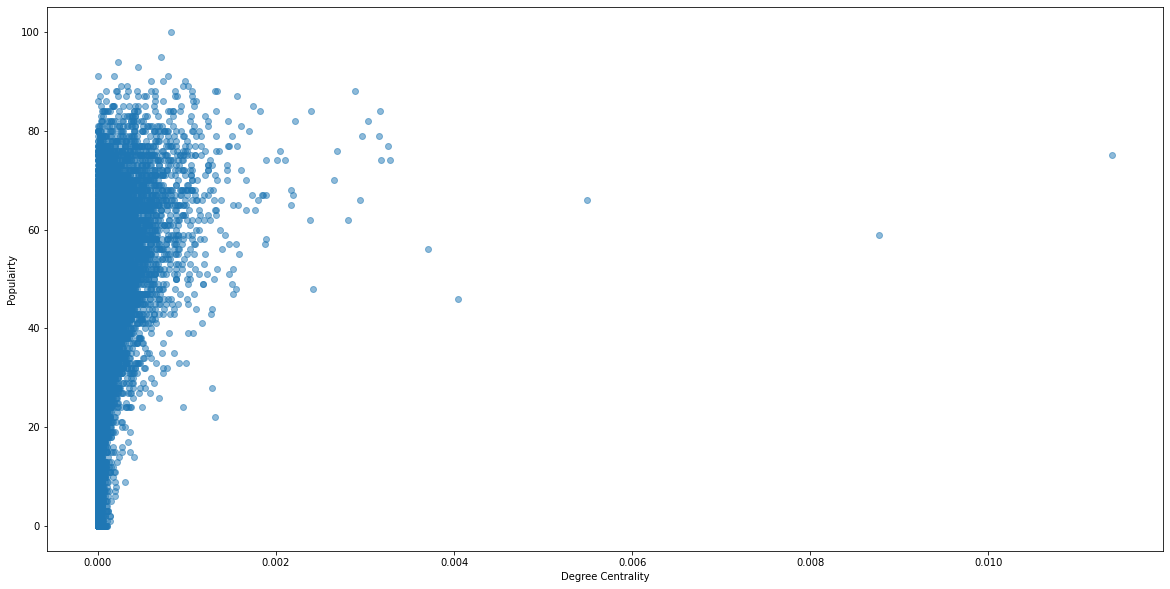

In [93]:
from scipy import stats
plt.figure(figsize=(20, 10)) 
plt.scatter(p,popularity_values,alpha=0.5)
plt.xlabel('Degree Centrality')
plt.ylabel('Populairty')
stats.spearmanr(p,popularity_values)

In [ ]:
#to be uncommented to see the plot for betweeness centrality
'''
plt.figure(figsize=(20, 10)) 
plt.scatter(betweeness_centrality_values,popularity_values,alpha=0.5)
plt.xlabel('Betweeness Centrality')
plt.ylabel('Populairty')
stats.spearmanr(deg_centrality_values,popularity_values)
'''

**Popularity and Genre**

In [116]:
artist_genre_dict = dict()

for index, row in artists.iterrows():
  artist_genre_dict[row['spotify_id']] = row['genres']

In [137]:
artist_popularity_dict = dict()

for index, row in artists.iterrows():
    artist_popularity_dict[row['spotify_id']] = row['popularity']

In [126]:
source_genre = []
target_genre = []

for index, row in feats.iterrows():
  if row['id_0'] in artist_genre_dict.keys():
      source_genre.append(artist_genre_dict[row['id_0']])
      if row['id_1'] in artist_genre_dict.keys():
        target_genre.append(artist_genre_dict[row['id_1']])

source_genre.append('dancehall')
source_genre.append('lovers rock')
source_genre.append('modern reggae')
source_genre.append('classic swedish pop')
source_genre.append('norrbotten indie')
target_genre.append('dancehall')   
target_genre.append('lovers rock')
target_genre.append('modern reggae')
target_genre.append('classic swedish pop')
target_genre.append('norrbotten indie')
target_genre.append('classic swedish pop')
target_genre.append('norrbotten indie')
feats['source_genre'] = source_genre
feats['target_genre'] = target_genre

In [143]:
source_popularity = []
target_popularity = []

for index, row in feats.iterrows():
  if row['id_0'] in artist_popularity_dict.keys():
    source_popularity.append(artist_popularity_dict[row['id_0']])
    if row['id_1'] in artist_popularity_dict.keys():
      target_popularity.append(artist_popularity_dict[row['id_1']])

source_popularity.append(0) 
source_popularity.append(0)  
source_popularity.append(0)  
source_popularity.append(0)  
source_popularity.append(0) 
target_popularity.append(0) 
target_popularity.append(0)  
target_popularity.append(0)  
target_popularity.append(0)  
target_popularity.append(0) 
target_popularity.append(0)
target_popularity.append(0)  
feats['source_popularity'] = source_popularity
feats['target_popularity'] = target_popularity
feats['popularity']=max(source_popularity,target_popularity)


In [192]:
intra_list = []
inter_list = []

for genre in genreList.values():
  print(genre)
  feats_genre_genre = feats[feats['source_genre'].isin([genre])]
  feats_genre_genre  = feats_genre_genre [feats_genre_genre ['target_genre'].isin([genre])]
  intra_list.append(np.mean(feats_genre_genre['popularity'].tolist()))
    
  feats_genre = feats_genre_genre
  feats_genre_other = feats_genre[~feats_genre['target_genre'].isin([genre])]
  feats_genre_1 = feats[feats['target_genre'].isin([genre])]
  feats_genre_other_1 = feats_genre_1[~feats_genre_1['source_genre'].isin([genre])]
  feats_genre_other_all = pd.concat([feats_genre_other,feats_genre_other_1]).drop_duplicates(subset=['id_0','id_1'])
    
  inter_list.append(np.mean(feats_genre_other_all['popularity'].tolist()))

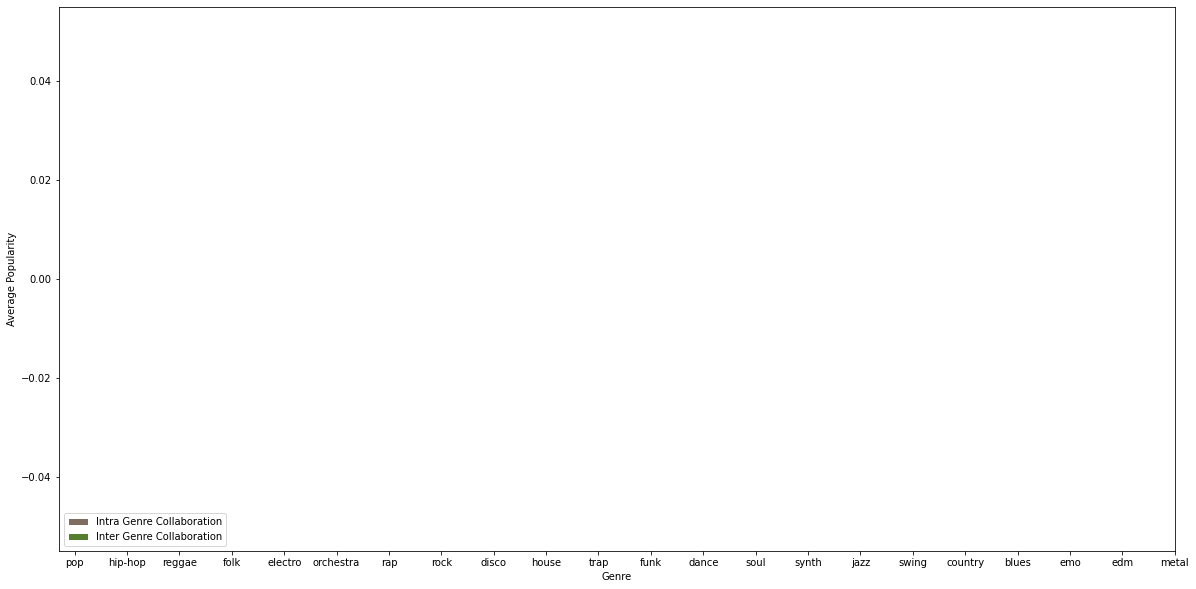

In [182]:
barWidth =0.25

intra = intra_list
inter = inter_list

r1 = np.arange(len(intra))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(20,10))

plt.bar(r1, intra, color='#7f6d5f', width=barWidth, edgecolor='white', label='Intra Genre Collaboration')
plt.bar(r2, inter, color='#557f2d', width=barWidth, edgecolor='white', label='Inter Genre Collaboration')

plt.xlabel('Genre')
plt.ylabel('Average Popularity')
plt.xticks([r + barWidth for r in range(len(intra))], genreList.values())

plt.legend()
plt.show()

## Community analysis ##
1- Community detection (try to run an estimation of how many genres there are to determine k): 
 - We will use Spectral clustering, as it allows up to pick K -> sklearn implementation <br/>
 
propagation of sampled assignments via nearest neighbor
<br/>

2- evaluation with paper metrics: <br/>
https://www.cs.rpi.edu/~szymansk/papers/SocCom-metric.13.pdf <br/>
https://arxiv.org/pdf/1610.03176.pdf 
<br/>

3- Alignment of communities with e.g. genre subgraphs, how accurate are the communities detected to the subraphs of music genres  <br/>

In [ ]:
# Spectral clustering functions
# computing the adjacency matrix
# print the amount of genres in the graph and try to see if community analyisis can coincide
def compute_adjmat(H):
    index_ids = dict()
    ids_index = dict()
    i = 0
    for ID in H.nodes:
        index_ids.update({ID:i})
        ids_index.update({i:ID})
        i += 1

    AdjMat = np.empty((len(H.nodes), len(H.nodes)))
    for edge in list(H.edges):
        AdjMat[index_ids.get(edge[0]), index_ids.get(edge[1])] = 1
        AdjMat[index_ids.get(edge[1]), index_ids.get(edge[0])] = 1
    return AdjMat

# computing the L matrix
def compute_L(H):
    index_ids = dict()
    ids_index = dict()
    i = 0
    for ID in H.nodes:
        index_ids.update({ID:i})
        ids_index.update({i:ID})
        i += 1
        
    AdjMat = compute_adjmat(H)
    L = np.zeros((len(H.nodes), len(H.nodes)))
    for i in range(len(H.nodes)):
        L[i,i] = H.degree[ids_index.get(i)]
    
    L = L - AdjMat
    return L


def spectral_cluster(H, accuracy= 1e-10, k = 0):
    # find k wth given accuracy
    AdjMat = compute_adjmat(H)
    if k == 0:
        L = compute_L(H)
        w,v = np.linalg.eig(L)
        zeros = [x for x in w if abs(x) < 0 + accuracy]
        k = len(zeros)
    communities = SpectralClustering(n_clusters=k, assign_labels='discretize', random_state=0, affinity='precomputed').fit(AdjMat)
    return communities.labels_

######################## TEST SAMPLING METHOD #############################
Ref_Graph = H #modify this with other sampling methods to compare
###########################################################################

clustering = spectral_cluster(Ref_Graph, k = len(macroGenres))


C:\Users\Giovanni\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:
# Is this closer to the groud truth of G?
print('total labels = ', len(macroGenres))
print('first 10 labels:', clustering[0:10])

# we will take G2 as our ground truth, but now it's time to propagate our results from the sampled graph onto G!

total labels =  23
first 10 labels: [18  5  5 10 19  5 18  0  5  1]


Number of nodes in community  3 :  11


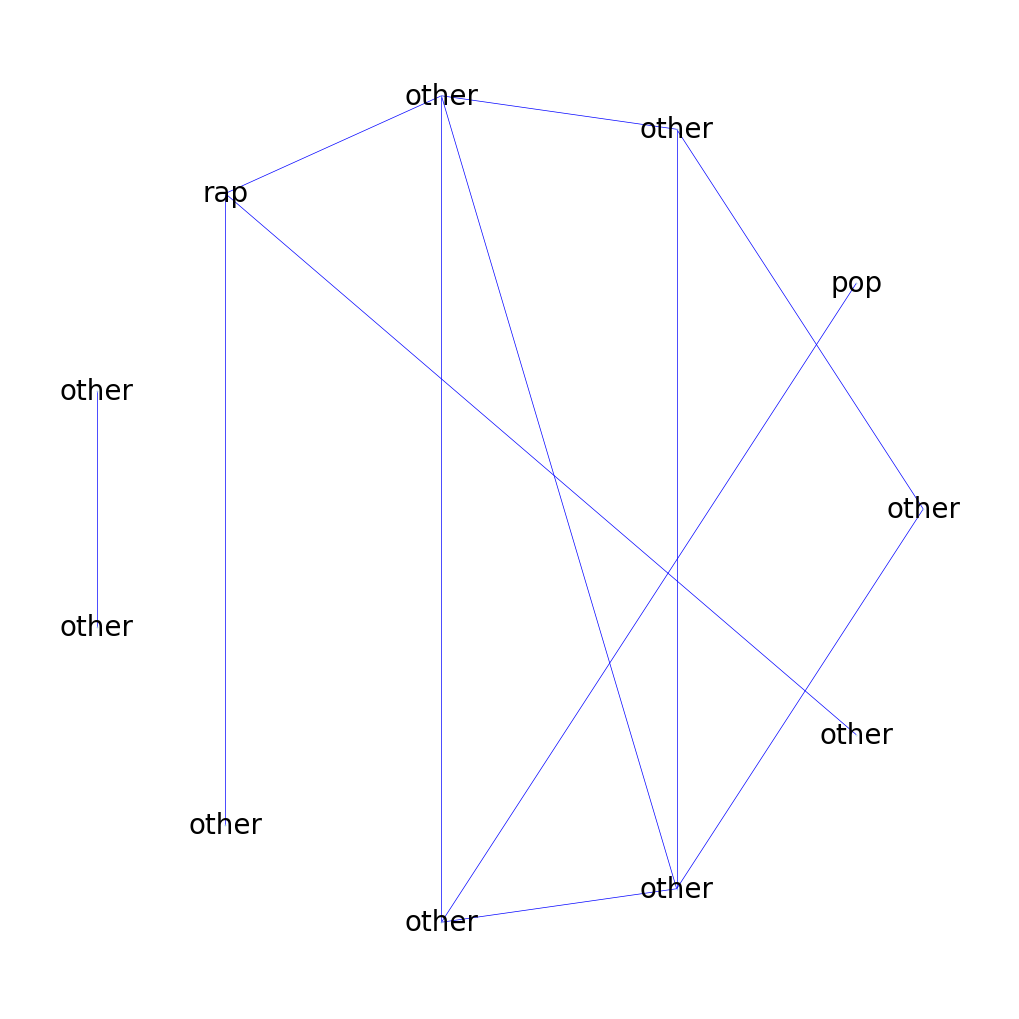

In [ ]:
def print_community(H, assignments, communityIndex):
    Comm = nx.Graph()
    ids = list(H.nodes)
    subgraphNodes = []
    for i in range(len(ids)):
        if assignments[i] == communityIndex:
            subgraphNodes.append(ids[i])
            
    Comm = H.subgraph(subgraphNodes)
    labels = nx.get_node_attributes(Comm, 'genres')
    
    g_draw = Comm

    fig = plt.figure(figsize=(10,10))
    pos = nx.circular_layout(g_draw)
    nx.draw(g_draw, pos, node_color='lightblue', edge_color='blue', node_size=0.1, labels = labels,
            with_labels = True, width=0.5, font_size = 20)
    
i = 3
print('Number of nodes in community ', i, ': ', clustering.tolist().count(i))
print_community(Ref_Graph, clustering, i)
plt.savefig('./Figures/ExampleCommunity.png',dpi=300)

In [ ]:
# propagate communities onto G2
Gclustering = - np.ones(len(G2.nodes))

# initialize assignments of subgraph on G
Hids_index = dict()
i = 0
for ID in Ref_Graph.nodes:
    Hids_index.update({i:ID})
    i += 1

Gids_index = dict()
Gindex_ids = dict()
i = 0
for ID in G2.nodes:
    Gids_index.update({i:ID})
    Gindex_ids.update({ID:i})
    i += 1
    

for i in range(len(Ref_Graph.nodes)):
    nodeID = Hids_index.get(i)
    Gclustering[Gindex_ids.get(nodeID)] = clustering[i]
    
print(Gclustering[:100])
# now we have partial G assignments, all that's left is to propagate them by diffusion, 
# one layer of neighbors at a time

[-1. 18. -1.  5. -1. -1. -1. -1. -1. -1. -1. -1. 22. -1. -1. -1. -1. -1.
 -1. -1.  5. -1.  6.  5. -1.  5. -1. 18. 19. 11. -1. -1. -1. -1.  5. -1.
 -1. -1. -1.  5. -1. -1.  5. -1.  7.  5. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  5. -1. -1.  0.  0. -1. -1. -1. -1. -1. -1.  5.  7. -1. -1. -1. -1.
 -1. -1.  5. 18. -1. -1. -1. -1.  5. -1. -1. 19. -1.  5.  5. -1. -1. -1.
  0. -1. -1. -1. -1. -1. 18. -1. -1.  0.]


In [ ]:
# calculate max degree to know how much to iterate
comps = nx.connected_components(G2)

maxdeg = 0
for comp in comps:
    sub = G2.subgraph(comp)
    deg = nx.approximation.diameter(sub)
    if deg > maxdeg:
        maxdeg = deg
        
print("Maximum degree is:", maxdeg)

Maximum degree is: 24


In [ ]:
# propagation of labels
for k in range(maxdeg): #graph is not connected, some nodes may never get assigned (-1)
    for i in range(len(Gclustering)):
        if Gclustering[i] != -1:
            l = Gclustering[i]
            neighbors = np.array(list(G2.neighbors(Gids_index[i])))
            neighbor_indices = [Gindex_ids[i] for i in neighbors]
            for index in neighbor_indices:
                Gclustering[index] = l
                    
print("first 100 assignments on G2:", Gclustering[:100])

first 100 assignments on G2: [ 5. 18. 18.  5.  5.  9.  7.  5.  5. 18.  5. -1. 22. -1. 18.  5. -1.  7.
 -1. 13.  5. 18. 18.  5. -1.  5.  5.  5. 19. 11. 16.  5. -1.  1.  5.  4.
  5. -1. -1.  5.  5. -1.  5. -1.  7. 18.  5. 11.  5.  5. -1. 11.  5.  5.
  5.  5. 16. 18.  0.  0. -1. -1.  0. 18.  6.  5.  5.  7. -1.  5.  5.  6.
  6. 16.  5. 18. -1.  5.  5. -1.  0.  5. 22.  5. 18.  5.  5.  5.  1.  5.
  5.  1. -1.  5. -1. 16.  5. 18.  5.  0.]


In [ ]:
# prune graph of unconnected nodes
G3 = G2.copy() # G3 is our pruned graph
G3clustering = Gclustering.tolist()
i = 0
for i in range(len(Gclustering)):
    if Gclustering[i] == -1:
        ID = Gids_index[i]
        G3clustering.remove(-1)
        G3.remove_node(ID)
        
G3clustering = np.array(G3clustering)
print(len(G3.nodes), ' = ', len(G3clustering))
print("first 100 assignments on G3:", G3clustering[:100])

148594  =  148594
first 100 assignments on G3: [ 5. 18. 18.  5.  5.  9.  7.  5.  5. 18.  5. 22. 18.  5.  7. 13.  5. 18.
 18.  5.  5.  5.  5. 19. 11. 16.  5.  1.  5.  4.  5.  5.  5.  5.  7. 18.
  5. 11.  5.  5. 11.  5.  5.  5.  5. 16. 18.  0.  0.  0. 18.  6.  5.  5.
  7.  5.  5.  6.  6. 16.  5. 18.  5.  5.  0.  5. 22.  5. 18.  5.  5.  5.
  1.  5.  5.  1.  5. 16.  5. 18.  5.  0.  7. 18. 18.  5.  5.  5. 18. 18.
 12. 12.  5.  5. 18. 18. 18.  5.  5.  5.]


In [ ]:
# compute the percentage of genres in each cluster
# TODO
G3ids_index = dict()
i = 0
for ID in G3.nodes:
    G3ids_index.update({i:ID})
    i += 1

communityDistrib = np.zeros((23,23))
print(macroGenres)
G3labels = nx.get_node_attributes(G3, 'genres')

for i in range(len(G3labels)):
    communityDistrib[int(G3clustering[i])][macroGenres.index(G3labels[G3ids_index[i]])] += 1
    
for i in range(len(communityDistrib)):
    communityDistrib[i] = communityDistrib[i] * 100 / np.sum(communityDistrib[i]) #mean the results to obtain percentages
    
for i in range(len(communityDistrib)):
    print([f'{item:.2f}' for item in communityDistrib[i]])

['other', 'pop', 'hip-hop', 'reggae', 'folk', 'electro', 'orchestra', 'rap', 'rock', 'disco', 'house', 'trap', 'funk', 'dance', 'soul', 'synth', 'jazz', 'swing', 'country', 'blues', 'emo', 'edm', 'metal']
['79.02', '7.26', '0.00', '1.05', '0.23', '0.66', '0.06', '5.17', '0.88', '0.08', '0.99', '0.00', '2.84', '0.35', '0.35', '0.01', '0.46', '0.06', '0.10', '0.02', '0.00', '0.37', '0.05']
['85.85', '8.80', '0.00', '0.30', '0.31', '0.39', '0.06', '2.23', '0.62', '0.05', '0.27', '0.00', '0.05', '0.09', '0.09', '0.02', '0.39', '0.00', '0.09', '0.02', '0.06', '0.22', '0.09']
['63.51', '1.35', '0.00', '0.00', '0.00', '0.00', '0.00', '32.43', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.35', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.35', '0.00']
['91.13', '8.06', '0.00', '0.00', '0.00', '0.81', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['95.83', '4.17', '0.00', '0.00', '0.00', '0.00', 

Ground truth subgraph of genre rock :
Community clustering of label 8 :


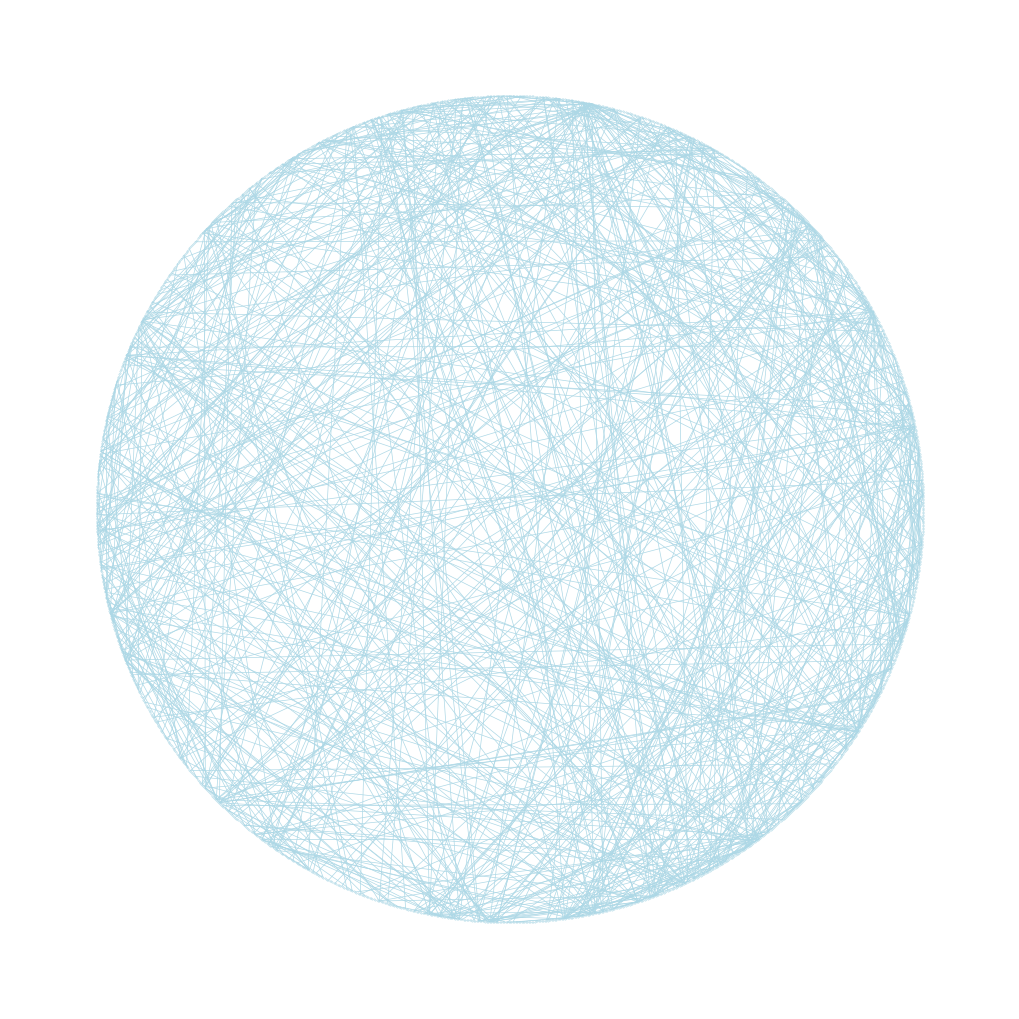

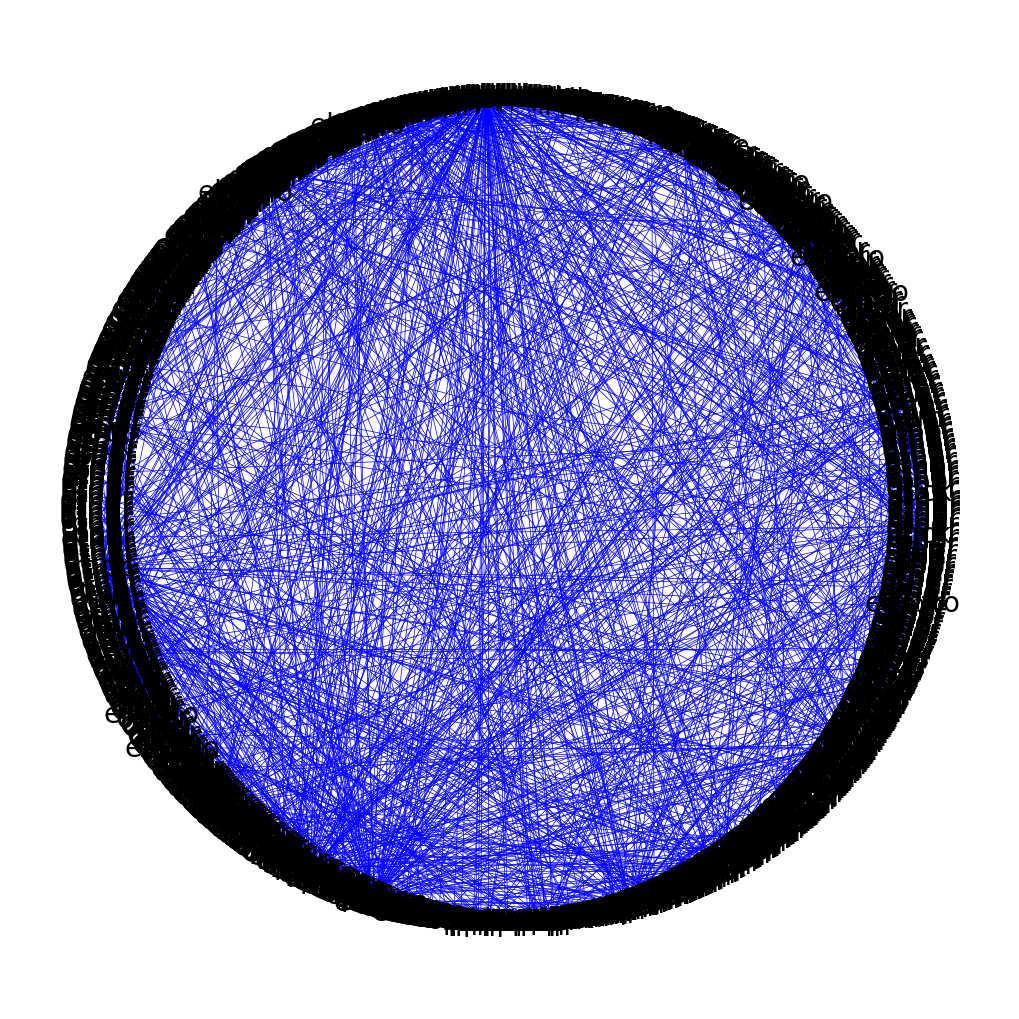

In [ ]:
# how does this compare to genre subgraphs?
i = 8
    
print('Ground truth subgraph of genre', macroGenres[i],':')
print_genre(G3, macroGenres[i])
    
print('Community clustering of label', i, ':')
print_community(G3, G3clustering, i)